In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
# import seaborn as sns

https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb

### 1. Build Dataset based on block size

In [5]:
# read names
with open('names.txt', 'r') as f:
    names = f.readlines()
names = [name.strip() for name in names]

In [9]:
# build chars to int mapping
chars = '.abcdefghijklmnopqrstuvwxyz'
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for i, c in enumerate(chars)}

In [15]:
# --- build dataset based on block size ie how many chars do we take to predict the next one
def build_dataset(names: [str], block_size: int = 3):
    X, Y = [], []
    for name in names:
        context = [0] * block_size
        for ch in list(name) + ['.']:
            idx = ctoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [25]:
# --- split into training and testing set

# creating dataset
X, Y = build_dataset(names=names, block_size=3)

# generating random indexes
indexes = list(range(X.shape[0]))
random.shuffle(indexes)
train_perc = 0.8
train_size = int(X.shape[0] * train_perc)

# spliting 
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [28]:
print(X_train.shape, Y_train.shape)

torch.Size([182516, 3]) torch.Size([182516])


In [ ]:
# build chars-int dictionary: mapping from subsequence of chars to int


In [ ]:
# encode with one-hot encoding (?)



### 2. Build and Train Embedding

In [128]:
# initialize embedding -> each character is represented by a vector of {vector_size}
# initialize MLP layers -> we have two layers
# layer 1: dim W1: (vector_size * block_size, t1)
# layer 2: dim W2: (1, 27) ie 27: num of chars
vector_size = 10
g = torch.Generator().manual_seed(420)
C = torch.randn((27, vector_size), generator=g)
embedding = C[X] # shape: [228146, 3, 2]
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [C, W1, b1, W2, b2]

In [129]:
# num of parameters in total
sum(p.nelement() for p in params)

11897

In [130]:
# set parameters to training mode
for p in params:
    p.requires_grad = True

In [131]:
X_train[[1,2,3]]

tensor([[ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13]])

In [132]:
# mini-batch gradient descent + learning rate decay
num_epochs = 200000
batch_size = 32
n = X_train.shape[0]

losses = []
for i in range(num_epochs):
    # indexing mini-batch
    indexes = torch.randint(low=0, high=n, size=(batch_size,))
    
    # forward pass
    emb = C[X_train[indexes]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, Y_train[indexes])
    losses.append(loss)
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data -= lr * p.grad

    # print loss
    if i % 5000 == 0:
        print(f"Epoch {i}: {loss}")

Epoch 0: 23.77777099609375
Epoch 5000: 3.533219814300537
Epoch 10000: 2.819716453552246
Epoch 15000: 2.279491662979126
Epoch 20000: 2.2140583992004395
Epoch 25000: 1.9915820360183716
Epoch 30000: 2.4069290161132812
Epoch 35000: 3.1096560955047607
Epoch 40000: 2.4751720428466797
Epoch 45000: 2.4331893920898438
Epoch 50000: 2.5955281257629395
Epoch 55000: 2.039189577102661
Epoch 60000: 2.14447021484375
Epoch 65000: 2.6180381774902344
Epoch 70000: 2.8942902088165283
Epoch 75000: 2.0928733348846436
Epoch 80000: 2.189805507659912
Epoch 85000: 2.15787410736084
Epoch 90000: 2.294736385345459
Epoch 95000: 2.035386085510254
Epoch 100000: 2.164144277572632
Epoch 105000: 2.128009080886841
Epoch 110000: 1.6010549068450928
Epoch 115000: 2.2479536533355713
Epoch 120000: 2.105144739151001
Epoch 125000: 1.9377598762512207
Epoch 130000: 2.453157663345337
Epoch 135000: 1.7534037828445435
Epoch 140000: 1.9535577297210693
Epoch 145000: 2.2752206325531006
Epoch 150000: 2.630537986755371
Epoch 155000: 1.860

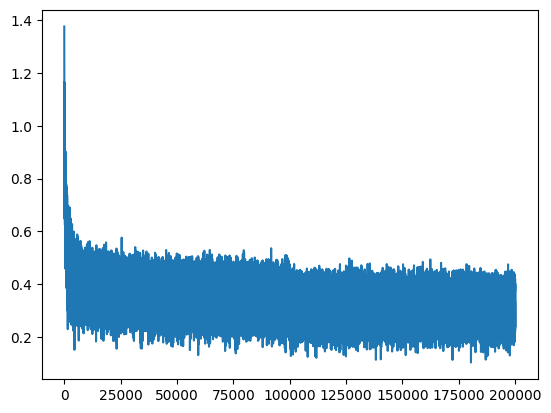

In [137]:
steps = list(range(num_epochs))
plt.plot(steps, torch.tensor(losses).log10())

### 3. Visualize Embedding

- visualization with t-sne (or alternative dimension reduction algo)

### 4. Sample from model

In [138]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [151]:
def generate_name():
    letters = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        letters.append(itoc[idx])

        if idx == 0:
            break

    return ''.join(letters[:-1])

t = generate_name()

In [152]:
t

'alaytelee'